#  ***k-NN and Decision Tree on Wisconsin Cancer Dataset***
## *Class*: COSC528 - Project 3
### *Author*: Ian R. Stewart
### *Due Date*: November 6, 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
savePath = '/Users/i6o/Research/COSC 528/Project 3/Figures/'

## 1) Data Exploration

In [2]:
# Reading data
features = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
df = pd.read_csv('breast-cancer-wisconsin.data',names=features)
'''
------------------------------------------
     Details for DataFrame Features
------------------------------------------
1. Sample code number: id number 
2. Clump Thickness: 1 – 10
3. Uniformity of Cell Size: 1 – 10 
4. Uniformity of Cell Shape: 1 – 10 
5. Marginal Adhesion: 1 – 10
6. Single Epithelial Cell Size: 1 – 10 
7. Bare Nuclei: 1 – 10
8. Bland Chromatin: 1 – 10
9. Normal Nucleoli: 1 – 10
10. Mitoses: 1 – 10
11. Class: (2 for benign, 4 for malignant)
'''
df.head(1)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2


In [3]:
df.dtypes

Sample code number              int64
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [4]:
# Dropping rows with '?' values in Bare Nuclei feature.
df['Bare Nuclei'] = df['Bare Nuclei'].astype(str)
count=0;indexes=[]
for i in df['Bare Nuclei']:
    try:
        j = float(i)
    except:
        indexes.append(count)
    count+=1
df = df.drop(indexes)
df['Bare Nuclei'] = df['Bare Nuclei'].astype(int)
df.dtypes

Sample code number             int64
Clump Thickness                int64
Uniformity of Cell Size        int64
Uniformity of Cell Shape       int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

In [5]:
#sns.pairplot(df[features[1::]],hue='Class',palette='coolwarm')
#plt.savefig(savePath+'full_pairplot.png',dpi=600)

Creating function to split data into training and test sets.

In [6]:
def test_split(data_x,data_y,n):
    '''
    Description: Splits <data> variable into four random 
        parts based on <n> percentage of data for training 
        set.
    
    :param data_x {array} : x data to split,train,predict
    :param data_y {array} : y data to split,train,predict
    :param n      {float} : percentage of data to split
    
    :returns {6}: (x_train,x_test,y_train,y_test) ;     
        x_train = training set for <x> parameter
        x_test  = test set for <x> parameter
        y_train = training set for <y> paramter
        y_test  = test set for <y> parameter
        i_train = indexes of training set split
        i_test  = indexes of test set split
    
    e.g. x_tr,x,y_tr,y,i_tr,i_test=test_split(data,data_to_predict,40)
    '''
    data_x = np.asarray(data_x)
    length_test = int(round(len(data_x)*(n/100.)))
    # Create random integers between two numbers with no repeats
    train_list = random.sample(range(0,len(data_x)), length_test)
    train_list.sort()
    test_list = np.arange(0,len(data_x))
    test_list = np.delete(test_list,train_list)
    data_y = np.array(data_y)
    x_train,y_train = np.array(data_x[train_list]),np.array(data_y[train_list])
    x_test,y_test   = np.array(data_x[test_list]),np.array(data_y[test_list])
    
    return (x_train,x_test,y_train,y_test,train_list,list(test_list))

Not using *Sample Code No.* in analysis. Using the *Class* feature as the predictor parameter and the other features (minus the *Sample Code No.*) as the estimating parameters. Also, *z*-standardizing data

In [28]:
df_standardized = (df-df.mean())/df.std()
data_x = df_standardized.iloc[:,1:-2]
data_y = df.iloc[:,-1]
print data_x.shape,data_y.shape

(683, 8) (683,)


In [29]:
x_train,x_test,y_train,y_test,train_list,test_check = test_split(data_x,data_y,30)

In [30]:
# Checking split shapes
print 'Training set shapes: \n\t{ Data:%s,\tPredictor:%s }'%(x_train.shape,y_train.shape)
print 'Test set shapes: \n\t{ Data:%s,\tPredictor:%s }'%(x_test.shape,y_test.shape)

Training set shapes: 
	{ Data:(205, 8),	Predictor:(205,) }
Test set shapes: 
	{ Data:(478, 8),	Predictor:(478,) }


Testing Scikit-Learns KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [32]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
pred = knn.predict(x_test)
print confusion_matrix(y_test,pred)
print '\n'
print classification_report(y_test,pred)

[[313   8]
 [ 10 147]]


             precision    recall  f1-score   support

          2       0.97      0.98      0.97       321
          4       0.95      0.94      0.94       157

avg / total       0.96      0.96      0.96       478



Text(0.5,0,u'k (No. of Neighbors)')

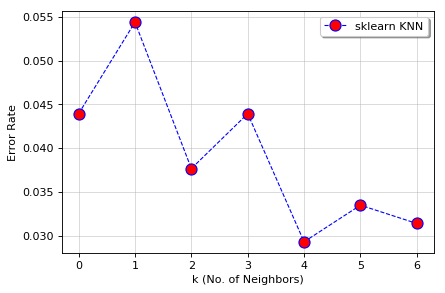

In [34]:
error_rate = []
for i in range(1,8):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i!=y_test))
plt.figure(dpi=80)
plt.plot(error_rate,'bo--',linewidth=1,markerfacecolor='red',markersize=10,label='sklearn KNN')
plt.grid(alpha=0.5)
plt.legend(loc='upper right',fancybox=True,shadow=True)
plt.ylabel('Error Rate');plt.xlabel('k (No. of Neighbors)')

In [92]:
import operator;

class KNN_class():
    
    def __init__(self,dataframe,k=2,split=30):
        self.data_x = np.array(dataframe.iloc[:,1:-2])
        self.data_y = np.array(dataframe.iloc[:,-1])        
        self.k = k
        self.split = split
        
    def test_split(self,data_x,data_y,split):
        length_test = int(round(len(self.data_x)*(self.split/100.)))
        train_list = random.sample(range(0,len(self.data_x)), length_test)
        train_list.sort()
        test_list = np.arange(0,len(self.data_x))
        test_list = np.delete(test_list,train_list)
        data_y = np.array(self.data_y)
        x_train,y_train = np.array(self.data_x[train_list]),np.array(self.data_y[train_list])
        x_test,y_test   = np.array(self.data_x[test_list]),np.array(data_y[test_list])
        return (x_train,x_test,y_train,y_test,train_list,list(test_list)) 
    
    def distance_func(self,train_values,test_values):
        d = 0
        for x in range(len(train_values)):
            d+=np.square(train_values[x] - test_values[x])
        distance = np.sqrt(distance)
        return distance
    
    def getNeighbors(self,x_set,y_set):
        distances = self.distance_func(x_set,y_set)
        predictions = np.zeros(distances.shape[0])
        for i in range(distance.shape[0]):
            k_distances = []
            class_labels = self.y_train[np.argsort(dists[i,:])].flatten()
            k_distances = class_labels[:self.k]
            class_values = Counter(k_distances)
            predictions[i] = class_values.most_common(1)[0][0]
        return predictions
    
    def getResponse(neighbors):
        classVotes = {}
        for x in range(len(neighbors)):
            response = neighbors[x][-1]
            if response in classVotes:
                classVotes[response] += 1
            else:
                classVotes[response] = 1
        sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
        return sortedVotes[0][0]

    def main(self):
        x_train,x_test,y_train,y_test,train_list,test_list = test_split(self.data_x,self.data_y,self.split)
        for x in range(len(y_train)):
            neighbors = self.getNeighbors(x_train, y_train[x])
            result = getResponse(neighbors)
            predictions.append(result)
        

In [93]:
k_nn = KNN_class(df_standardized)

In [94]:
k_nn.main()

IndexError: invalid index to scalar variable.

In [77]:
# Defining a function which calculates euclidean distance between two data points
def euclideanDistance(data1, data2, length):
    distance = 0
    for x in range(length):
        distance += np.square(data1[x] - data2[x])
    return np.sqrt(distance)

# Defining our KNN model
def knn(trainingSet, testInstance, k):
 
    distances = {}
    sort = {}
 
    length = testInstance.shape[1]
    
    #### Start of STEP 3
    # Calculating euclidean distance between each row of training data and test data
    for x in range(len(trainingSet)):
        
        #### Start of STEP 3.1
        dist = euclideanDistance(testInstance, trainingSet.iloc[x], length)

        distances[x] = dist[0]
        #### End of STEP 3.1
 
    #### Start of STEP 3.2
    # Sorting them on the basis of distance
    sorted_d = sorted(distances.items(), key=operator.itemgetter(1))
    #### End of STEP 3.2
 
    neighbors = []
    
    #### Start of STEP 3.3
    # Extracting top k neighbors
    for x in range(k):
        neighbors.append(sorted_d[x][0])
    #### End of STEP 3.3
    classVotes = {}
    
    #### Start of STEP 3.4
    # Calculating the most freq class in the neighbors
    for x in range(len(neighbors)):
        response = trainingSet.iloc[neighbors[x]][-1]
 
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    #### End of STEP 3.4

    #### Start of STEP 3.5
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return(sortedVotes[0][0], neighbors)
    #### End of STEP 3.5

In [91]:
result,neigh = knn(df_standardized,df_standardized.iloc[:,][200::],2)

KeyError: 0

In [90]:
df_standardized.iloc[:,1:-2][200::].shape

(483, 8)